In [0]:
import numpy as np
from numpy import *
import cv2
import matplotlib.pyplot as plt

In [0]:
# ADAM IMPLEMENTATION
# w: The weights/biases (what is being updated)
# g: The gradient dL/dw
#
# i, m, v, beta1, beta2, and epsilon are adam specific parameters
#   i: Iteration number
#   m: Biased first moment estimate
#   v: Biased second raw moment estimate
#   beta1: Exponential decay rate for first moment estimates
#   beta2: Exponential decay rate for second moment estimates
#   epsilon: Small constant for numerical stability

def step_adam(i, m, v, w, g, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-10):
    # Get gradient -> g

    # Update biased first moment estimate
    m = (beta1 * m) + ((1 - beta1) * g)

    # Update biased second raw moment estimate
    v = (beta2 * v) + ((1 - beta2) * np.power(g, 2))

    # Compute bias-corrected first moment estimate
    beta1_i = np.power(beta1, i)
    if beta1_i == 1: m_hat = m
    else: m_hat = m / (1 - beta1_i)

    # Compute bias-corrected second raw moment estimate
    beta2_i = np.power(beta2, i)
    if beta2_i == 1: v_hat = v
    else: v_hat = v / (1 - beta2_i)
    
    # Update parameters
    den = np.sqrt(v_hat) + epsilon
    if isinstance(den, np.float):
      if den == 0: den = epsilon
    else: den[den == 0] = epsilon
    w = w - ((alpha * m_hat) / (den))

    # Return updates
    return [i+1, m, v, w]

def run_adam(w, g, alpha=0.001, num_iterations=1, m_init=0, v_init=0, i_init=0):
    # Initialize
    m = m_init
    v = v_init
    i = i_init
    
    # Loop through iterations
    for j in range(num_iterations):
        i, m, v, w = step_adam(i, m, v, w, g, alpha)
    
    return [i, m, v, w]

CNN CODE

In [0]:
class Conv:
  def __init__(self, num_filters, filter_size):
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size * filter_size) # normalize the values

    # Initialize for adam
    self.adam_i = 0
    self.adam_m = 0
    self.adam_v = 0

    # np.random.randn() https://ti.webex.com/ti/j.php?MTID=m33dd9bd21a635179a13915008b167b6e
    # padding?
    # stride?

  def image_region(self, image):
    # generator function
    height, width = image.shape
    self.image = image

    # need to vectorize this
    for i in range (height - self.filter_size + 1):
      for j in range (width - self.filter_size + 1):
        image_patch = image [i: (i + self.filter_size), j: (j + self.filter_size)]
        yield image_patch, i, j # stores all image patches
  
  def forward_prop(self, image):
    height, width = image.shape
    conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters))
    
    # need to vectorize this
    for image_patch, i, j in self.image_region(image):
      conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis = (1, 2))
    return conv_out

  def back_prop(self, dL_dout, learning_rate, optimizer):

    """
    add input parameter called optimizer w/ values ('gd', 'sgd', 'sgd_mom', 'sgd_nesterov', 'adam', 'rmsprop', etc...)
    check optimizer param against the input string and run the appropriate algorithm
    should be consistent w/ the value passed to the softmax layer

    if optimizer == 'gd':
      run_gd()
    
    if optimizer == 'sgd':
      run_sgd()

    ...
    """

    dL_dF_params = np.zeros(self.conv_filter.shape)

    # need to vectorize this
    for image_patch, i, j in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch * dL_dout[i,j,k]
    
    # weight update (gradient descent) - this should be configurable to any optimizer
    if optimizer == 'adam':
      self.adam_i, self.adam_m, self.adam_v, self.conv_filter = run_adam(self.conv_filter, dL_dF_params, learning_rate, m_init=self.adam_m, v_init=self.adam_v, i_init=self.adam_i)
    # ADD OTHER OPTIMIZERS HERE

    return dL_dF_params

In [0]:
class Max_Pool:
  def __init__(self, filter_size):
    self.filter_size = filter_size
  
  def image_region(self, image):
    new_height = image.shape[0] // self.filter_size
    new_width = image.shape[1] // self.filter_size
    self.image = image

    # need to vectorize this
    for i in range(new_height):
      for j in range(new_width):
        image_patch = image[(i*self.filter_size) : (i*self.filter_size + self.filter_size) , (j*self.filter_size) : (j*self.filter_size + self.filter_size)]
        yield image_patch, i, j

  def forward_prop(self, image):
    height, width, num_filters = image.shape
    output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    # need to vectorize this
    for image_patch, i, j in self.image_region(image):
      output[i, j] = np.amax(image_patch, axis=(0,1))

    return output 
  
  def back_prop(self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters = image_patch.shape
      maximum_val = np.amax(image_patch, axis=(0,1))

      # need to vectorize this 
      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if image_patch[i1, j1, k1] == maximum_val[k1]:
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1] = dL_dout[i, j, k1]
      
      return dL_dmax_pool  

In [0]:
class SoftMax:
  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node) / input_node
    self.bias = np.zeros(softmax_node)

    # Initialize for adam
    self.adam_i_w = 0
    self.adam_i_b = 0
    self.adam_m_w = 0
    self.adam_m_b = 0
    self.adam_v_w = 0
    self.adam_v_b = 0

  def forward_prop(self, image):
    self.orig_image_shape = image.shape
    modified_image = image.flatten()
    self.modified_input = modified_image
    output_val = np.dot(modified_image, self.weight) + self.bias
    self.out = output_val

    exp_out = np.exp(output_val)
    exp_out[np.isnan(exp_out)] = 0
    inf_indices = np.isinf(exp_out)
    if any(inf_indices):
      exp_out[inf_indices] = 1
      exp_out[np.invert(inf_indices)] = 0

    den = np.sum(exp_out, axis = 0)
    if den == 0: return exp_out
    return exp_out/den

  def back_prop(self, dL_dout, learning_rate, optimizer):

    """
    add input parameter called optimizer w/ values ('gd', 'sgd', 'sgd_mom', 'sgd_nesterov', 'adam', 'rmsprop', etc...)
    check optimizer param against the input string and run the appropriate algorithm
    should be consistent w/ the value passed to the conv layer

    if optimizer == 'gd':
      run_gd()
    
    if optimizer == 'sgd':
      run_sgd()

    ...
    """

    for i, grad in enumerate(dL_dout):
      if grad == 0:
        continue

      transformation_eq = np.exp(self.out)
      transformation_eq[np.isnan(transformation_eq)] = 0
      S_total = np.sum(transformation_eq)
      if np.isinf(S_total): S_total = 0

      # Gradients w/ respect to output (z)
      den = S_total ** 2
      if den != 0 and not np.isinf(den) and not np.isnan(den):
        dy_dz = -transformation_eq[i]*transformation_eq / (den)
        dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (den)
      else: dy_dz = np.zeros(transformation_eq.shape)

      # Gradients of totals against weights/biases/input
      dz_d_inp = self.weight
      dz_dw = self.modified_input # against weights
      dz_db = 1 # against biases

      # Gradients of loss against totals
      dL_dz = grad * dy_dz

      # Gradients of loss against weights/biases/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis] # against weights (@ => matrix multiplication operator)
      dL_db = dL_dz * dz_db # against biases
      dL_d_inp = dz_d_inp @ dL_dz # against input

      # Update weights and biases
      if optimizer == 'adam':
        self.adam_i_w, self.adam_m_w, self.adam_v_w, self.weight = run_adam(self.weight, dL_dw, learning_rate, m_init=self.adam_m_w, v_init=self.adam_v_w, i_init=self.adam_i_w)
        self.adam_i_b, self.adam_m_b, self.adam_v_b, self.bias = run_adam(self.bias, dL_db, learning_rate, m_init=self.adam_m_b, v_init=self.adam_v_b, i_init=self.adam_i_b)
      # ADD OTHER OPTIMIZERS HERE

      return dL_d_inp.reshape(self.orig_image_shape)
    
    return np.ones(self.orig_image_shape)

In [0]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
train_size = 6000
test_size = 1500
train_images = X_train[:train_size]
train_labels = y_train[:train_size]
test_images = X_test[:test_size]
test_labels = y_test[:test_size]

conv = Conv(8, 3)
pool = Max_Pool(2)
softmax = SoftMax(13 * 13 * 8, 10)
"""
class CNN:
  def __init__(self, )
"""

def feed_forward(image, label):
  out = conv.forward_prop((image / 255) - 0.5)
  out = pool.forward_prop(out)
  out = softmax.forward_prop(out)

  # Calculate cross-entropy loss and accuracy
  if out[label] != 0: cross_entropy_loss = -np.log(out[label])
  else: cross_entropy_loss = 0
  if np.isnan(cross_entropy_loss) or np.isinf(cross_entropy_loss): cross_entropy_loss = 0
  accuracy = 1 if np.argmax(out) == label else 0

  return out, cross_entropy_loss, accuracy

def train(image, label, optimizer, learning_rate = 0.01):

  # Forward
  out, loss, acc = feed_forward(image, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  if out[label] != 0: gradient[label] = -1 / out[label]

  # Backpropagation
  grad_back = softmax.back_prop(gradient, learning_rate, optimizer)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back, learning_rate, optimizer)

  return loss, acc

In [0]:
import time

optimizer = 'adam'

print('Training the CNN....')
start = time.time()

loss = 0
num_correct = 0
lossVals = []
accuVals = []

for epoch in range(10):
  print('Epoch %d ----> ' % (epoch + 1))

  # Shuffle the training data
  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  # Train the CNN
  for i, (img, label) in enumerate(zip(train_images, train_labels)):
    # print progress every 100 images 
    if i % 100 == 0:
      print('%d of 100 steps: Average loss %.3f and Accuracy: %d%%' % (i + 1, loss / ((i + 1) + epoch*train_size), (num_correct * 100 / ((i + 1) + epoch*train_size))))

    l1, accu = train(img, label, optimizer)
    
    lossVals.append(loss / ((i + 1) + epoch*train_size))
    accuVals.append(num_correct * 100 / ((i + 1) + epoch*train_size))

    loss += l1
    num_correct += accu

print(time.time()-start)

Training the CNN....
Epoch 1 ----> 
1 of 100 steps: Average loss 0.000 and Accuracy: 0%
101 of 100 steps: Average loss 2.260 and Accuracy: 36%
201 of 100 steps: Average loss 1.828 and Accuracy: 47%
301 of 100 steps: Average loss 1.564 and Accuracy: 54%
401 of 100 steps: Average loss 1.371 and Accuracy: 60%
501 of 100 steps: Average loss 1.290 and Accuracy: 63%
601 of 100 steps: Average loss 1.330 and Accuracy: 62%
701 of 100 steps: Average loss 1.269 and Accuracy: 63%
801 of 100 steps: Average loss 1.201 and Accuracy: 66%
901 of 100 steps: Average loss 1.179 and Accuracy: 66%
1001 of 100 steps: Average loss 1.155 and Accuracy: 66%
1101 of 100 steps: Average loss 1.139 and Accuracy: 67%
1201 of 100 steps: Average loss 1.095 and Accuracy: 68%
1301 of 100 steps: Average loss 1.053 and Accuracy: 69%
1401 of 100 steps: Average loss 1.031 and Accuracy: 69%
1501 of 100 steps: Average loss 1.009 and Accuracy: 70%
1601 of 100 steps: Average loss 0.970 and Accuracy: 71%
1701 of 100 steps: Averag

In [0]:
# Test the CNN
print('Testing the CNN....')
start = time.time()
test_lossVals = []
test_accuVals = []
loss = 0 
num_correct = 0
for i, (img, label) in enumerate(zip(test_images, test_labels)):
  _, l1, accu = feed_forward(img, label)
  loss += l1
  num_correct += accu
  test_lossVals.append(loss / (i+1))
  test_accuVals.append((num_correct * 100) / (i+1))

num_tests = len(test_images)
print('Test loss: ', loss / num_tests)
print('Test accuracy: ', num_correct / num_tests)
print(time.time() - start)

Testing the CNN....
Test loss:  4.0469543531101415
Test accuracy:  0.718
14.796372413635254


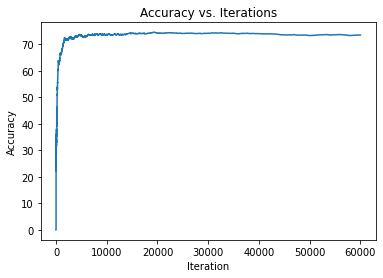

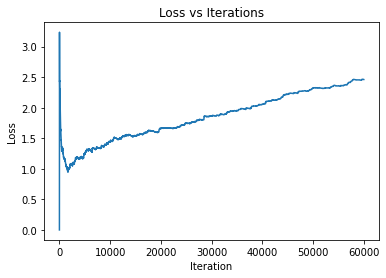

In [0]:
# Plots for training

plt.plot(accuVals)
plt.title("Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

plt.plot(lossVals)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

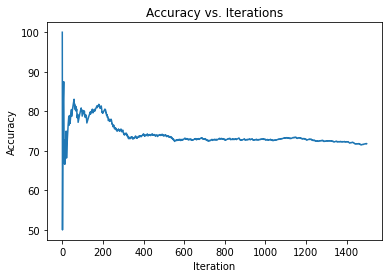

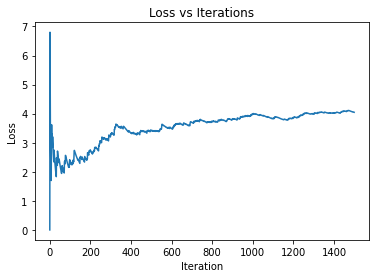

In [0]:
# Plots for testing

plt.plot(test_accuVals)
plt.title("Accuracy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

plt.plot(test_lossVals)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [0]:
# Add a csv file into google colab's files
# Save training accuracies and loss

import csv

with open('adam-training-01.csv', mode='w') as accu_loss:
    accu_loss_writer = csv.writer(accu_loss, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for accu, loss in zip(accuVals, lossVals):
      accu_loss_writer.writerow([accu, loss])
  
print ("Finished writing")

Finished writing


In [0]:
# Add a csv file into google colab's files
# Save testing accuracies and loss

import csv

with open('adam-testing-01.csv', mode='w') as accu_loss:
    accu_loss_writer = csv.writer(accu_loss, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for accu, loss in zip(test_accuVals, test_lossVals):
      accu_loss_writer.writerow([accu, loss])

print ("Finished writing")

Finished writing
